## **Machine Learning Project Notebook**
## **Part 2: Algorithm Implementation**

---
Co-author: James Wu (cw2961), Sophia Li (yl5582), Xingjian Gao (xg760)


---



This notebook represents the implementation of the algorithm as well as data visualization for the experimental results.
It would contain the following parts:


1.   Presetting of the system (e.g. importing required packages).
2.   Loading dataset (from drive). Note that the pre-processed data are stored in Google Drive for faster training. For details regarding data processing, you can check another notebook which mainly focuses on that part.
3.   Network construction and CNN related settings.
4.   Training, validating and testing.
5.   Visualization of the results from various metrics. 
**   Note that: the additional pictures for testing robustness of the trained model is contained in Google Drive of the notebook owner.




## Package Preloading


---

This section introduced some packages crucial to the implementation of this project.


1.   `Numpy`. Needless to say, this is an important package in dealing with high dimensions of data and achieve flexible interchanges among different data types. And its advantages in vectorization would also boost the model performance and training efficiency.
2.   `Torch`. The basic package for pytorch implementation.
3.   `Torchvision`. Pytorch's specialist module for dealing with pictures and figure-related data. It cooperates well with `Numpy` and other packages.
4.   `PIL.Image`. Reading and analyzing pictures, performing tasks like transforming figures and storing picture data.
5.   `Torch.nn`. The standard module for neural network constructions based on pytorch
6.   `os`. The standard module for file operations and configurations of the system environment.
7.   `matplotlib.pyplot`. The standard module for python plotting, will be used a lot in the visualization of model results.
Also, the project uses the data from Google Drive (for saving time). Hence, the team also imports the module for Google Drive mounting.

In [ ]:
# Required Packages Preloaded
import numpy as np
import torch
import torchvision
from PIL import Image
import torch.nn as nn
import os
import matplotlib.pyplot as plt

# Let's use data from Google Drive!!
from google.colab import drive
drive.mount('/content/drive', force_remount=False)


Mounted at /content/drive


Setting randomness in parts like Dataloaders to give randomness to the training processes.

In [ ]:
# Preset randomness

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True    

SEED = 45
seed_everything(SEED)

## Creating Dataset

Here we define the dataset class from `torch.utils.data`. The dataset is pre-processed loclaly and then uploaded to Google Drive. To call the functions related to the pre-loaded datasets (like` __get_item__`), it's important to implement the class before using them.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SymbolData(Dataset):
    def __init__(self, inputs, dataset_type, opd, transform=None):
        self.all_data = inputs
        self.dataset_type = dataset_type
        self.opd = opd
        self.all_tensors = []
        self.labels = [i[1] for i in self.all_data]

    def load_picture(self, file_name):
        loader = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))])
        image = Image.open(file_name)
        image = loader(image).unsqueeze(0)
        return image.to(torch.float)
    
    def process(self):
        self.all_tensors = [self.load_picture(os.path.join(self.opd, idx_label(i[1]), i[0])) for i in self.all_data]

    def __getitem__(self, index):
        pic_tensor = self.all_tensors[index]
        label = self.all_data[index][1]
        return pic_tensor, label
    
    def __len__(self):
        return len(self.all_data)

## Loading datasets from Google Drive
Additionally, for convenience, the list of all categories is preloaded as well.

In [ ]:
# Preload useful datas
import pickle
file_object = open('/content/drive/My Drive/output/final_data', 'rb')
all_cats = pickle.load(file_object)
train_data = pickle.load(file_object)
val_data = pickle.load(file_object)
test_data = pickle.load(file_object)
file_object.close()

# We check the length of the datasets
print(len(train_data), len(test_data), len(val_data))

225552 75161 75261


For better storing the information related to each category, this blcok creates a utility function, `idx_label`, which does the following:

1.   With an integer input as index, returns the corresponding category name
2.   With a category input in string format, returns the corresponding index (easier to store in tensors)



In [ ]:
# Utility function for transforming between index and category name
def idx_label(target):
    if target in all_cats:
        return all_cats.index(target)
    else:
        return all_cats[target]

Dataloader function definition. We do not use the default function as set in collfn. We define our own function `my_collfn` that processes data in the batch to be tuples containing input batch tensors and their categories (also as tensors).

In [ ]:
def my_collfn(batch):
    img = [item[0] for item in batch]
    other_info= [torch.tensor((item[1],)) for item in batch]
    img = torch.squeeze(torch.stack(img, 1),0)
    other_info= torch.cat(other_info, dim=0)

    return img, other_info

# Set training data loader

Enable GPU to achieve a significant boost in the training process

In [ ]:
# Enable GPU!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **Network** **Construction**
This block constructs the CNN structure we use for the model training. We have three convolutional layers with max-pooling layers connecting one layer with the following layer.

After the 3 convolutional layers, we use fully-connected layers to transform the data into the required form: a tensor with prediction values for each of the 82 categories.

To speed up the training, we used batch normalization (2-dim and 1-dim); to avoid the risks for overfitting, we used dropping-out mechanisms in the fully connected layers (we set the dropping probability as 0.5).
A simple visualization of this model can be seen in the final report presented by the team.

Note: all of the components are implemented through the `torch.nn` module.

In [ ]:
class CNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 16, 3, 1, 2),       
            nn.BatchNorm2d(16),  
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 4, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Sequential(
            nn.Linear(6 * 6 * 64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = dropout),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = dropout),
            nn.Linear(512, 82),
        )
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

## Hyperparameters Setting, Optimizer Selection and Result Storage
This block determines the hyperparameters related to the training and the optimizer to use.
Interpretations:


1.   EPOCH: training epochs.
2.   BATCH_SIZE: the batch of loading data for the Dataloaders
3.   TRUNC: determines the step of presenting result. Since we train the data via batches, within each training epoch, there will be several steps of training. Here we determine the "frequency" of the result presentation (we do validation on the specific steps).
4.   DROP_OUT: determines the probability of dropping out machinism. We usually us the defaul value as 0.5.
5.   `torch.optim.Adam(cnn.parameters(), lr=0.002)`: implements Adam optimizer with learning rate 0.002.
6.   `torch.optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)`: implements Stochastic Gradient Descent with learning rate 0.1 and momentum 0.9.
7.   `torch.optim.Adagrad(cnn.parameters())`: implements Adagrad optimizer.
8.   `torch.optim.RMSprop(cnn.parameters(), lr=0.001)`: implements RMSPropr with learning rate 0.001.

In the training process, we can uncomment the desired optimizer and comment others to use a specific optimizer.




In [ ]:
EPOCH = 25
BATCH_SIZE = 512
TRUNC = 45
DROP_OUT = 0.5
cnn = CNN(DROP_OUT).to(device)
cnn.train()


optimizer = torch.optim.Adam(cnn.parameters(), lr=0.002)
# optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9)
# optimizer = torch.optim.Adagrad(cnn.parameters())
# optimizer = torch.optim.RMSprop(cnn.parameters(), lr=0.001)



train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True, collate_fn=my_collfn, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=True, collate_fn=my_collfn, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True, collate_fn=my_collfn, drop_last=True)
print('Preset is done!')

Preset is done!


## Training the Model

This block presents training of the model. 

For measuring the model loss, we choose the Cross Entropy Loss via `nn.CrossEntropyLoss()` since it's a standard loss function in dealing with multi-class classification.

During the training, there will be checkpoints showing the performance of the current model (the train accuracy shows the accuracy involving the current training batch and the valid accuracy measures the accuracy on the whole validation set).

After the training, we will store the trained model in the notebook creater's Google drive.

In [ ]:
entropy=nn.CrossEntropyLoss()

loss_list = []
train_score = []
val_score = []

for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # Total Data/Batch = Final Steps
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        output = cnn(b_x)[0]            # cnn output
        loss = entropy(output, b_y)     # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()
        optimizer.step()                # back propagation

        if step % TRUNC == 0:
            train_y = torch.max(output, 1)[1].cpu().data.numpy()
            train_category = b_y.cpu().data.numpy()
            train_accuracy = float((train_y == train_category).astype(int).sum()) / float(len(train_category))
            train_score.append(train_accuracy)
            val_correct = 0
            # We measure the validation error over the whole set
            for _, (i, j) in enumerate(val_loader):
                test_img, test_cat = i.to(device), j
                test_output, _ = cnn(test_img)
                pred_y = torch.max(test_output, 1)[1].cpu().data.numpy()
                val_correct += (pred_y == test_cat.data.numpy()).astype(int).sum()
            accuracy = val_correct/len(val_data)
            loss_list.append(loss.cpu().data.numpy())
            val_score.append(accuracy)
            print('Epoch: {} | Loss: {} | Training Accuracy: {} | Validation Accuracy: {}'.format(epoch+1, loss.cpu().data.numpy(), train_accuracy, accuracy))

torch.save(cnn, '/content/drive/My Drive/output/model.pkl')

Epoch: 1 | Loss: 4.470190048217773 | Training Accuracy: 0.01171875 | Validation Accuracy: 0.27182737407156427
Epoch: 1 | Loss: 0.7501330375671387 | Training Accuracy: 0.8046875 | Validation Accuracy: 0.7940766133854188
Epoch: 1 | Loss: 0.4897446632385254 | Training Accuracy: 0.869140625 | Validation Accuracy: 0.8459627164135475
Epoch: 1 | Loss: 0.48451006412506104 | Training Accuracy: 0.8515625 | Validation Accuracy: 0.8677934122586731
Epoch: 1 | Loss: 0.3778117597103119 | Training Accuracy: 0.87890625 | Validation Accuracy: 0.8791804520269463
Epoch: 1 | Loss: 0.3418559730052948 | Training Accuracy: 0.8828125 | Validation Accuracy: 0.8887338727893597
Epoch: 1 | Loss: 0.3919728994369507 | Training Accuracy: 0.876953125 | Validation Accuracy: 0.8956298747027013
Epoch: 1 | Loss: 0.28595611453056335 | Training Accuracy: 0.90234375 | Validation Accuracy: 0.9021804121656635
Epoch: 1 | Loss: 0.428996741771698 | Training Accuracy: 0.87109375 | Validation Accuracy: 0.9032433797052922
Epoch: 1 |

### **Model Evaluation**
Below are the blocks evaluating the model from different perspectives. We will go through the following presentation:



1.   Traning Loss versus checkpoints
2.   Train and Validation Accuracy plot
3.   Test Accuracy Presentation
4.   Confusion Matrix Presentation
5.   Additional Data Prediction (via data in Google Drive)



Load the trained model

In [ ]:
model = torch.load('/content/drive/My Drive/output/model.pkl')
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, mo

Training Loss

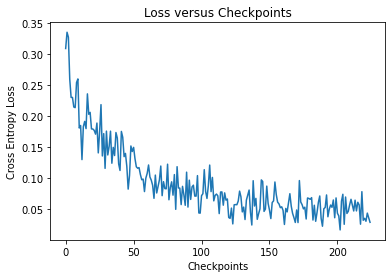

In [ ]:
# Training Loss Presentation
plt.plot(loss_list)
plt.xlabel('Checkpoints')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss versus Checkpoints')
plt.show()

Accuracy Comparison on Train and Validation Sets

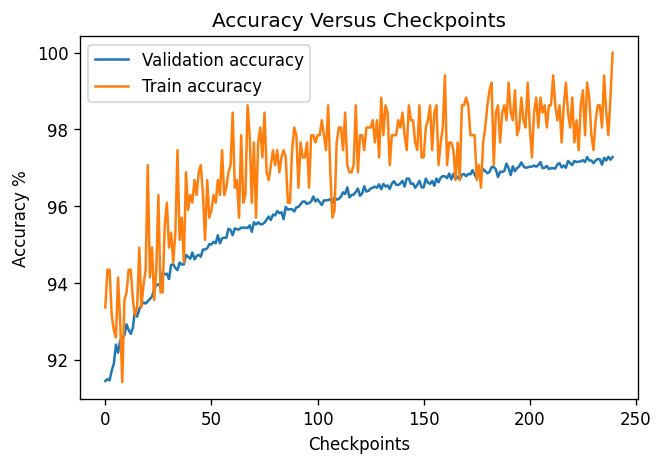

In [ ]:
# Accuracy Comparison on Train and Validation Sets
import matplotlib.pyplot as plt
plt.figure(dpi=120)
val_scores = [round(score, 4) * 100 for score in val_score]
plt.plot(val_scores[10:], label='Validation accuracy')
train_scores = [round(score, 4) * 100 for score in train_score]

plt.plot(train_scores[10:], label='Train accuracy')
plt.title('Accuracy Versus Checkpoints')
plt.xlabel('Checkpoints')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

Test Accuracy Calculation

In [ ]:
preds = []
reals = []
test_correct = 0
# cnn = CNN().to(device)
for _, (i, j) in enumerate(test_loader):
    vi, vc = i.to(device), j
    test_output, _ = cnn(vi)
    pred_y = torch.max(test_output, 1)[1].cpu().data.numpy()
    preds += list(pred_y.tolist())
    reals += list(vc.data.numpy())
    correct = (pred_y == vc.data.numpy()).astype(int).sum()
    test_correct += correct
print('Test Accuracy: ',test_correct/len(test_data))


Test Accuracy:  0.9715810061068906


Confusion Matrix Visualization

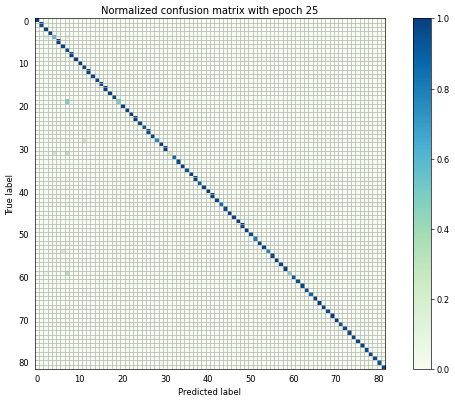

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels, y_true, y_pred = all_cats, reals, preds

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 8), dpi=60)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix with epoch {}'.format(EPOCH),cmap= 'GnBu')
# show confusion matrix
plt.show()

Additional Data Prediction

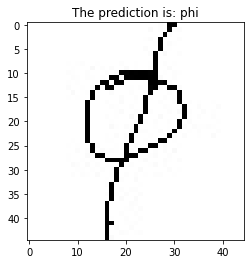

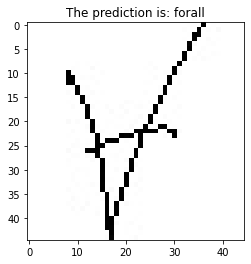

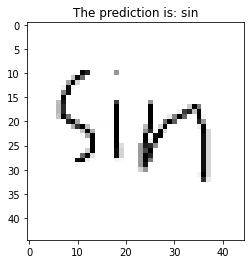

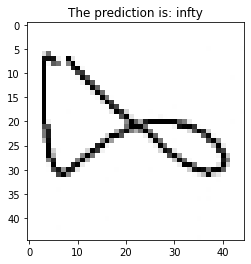

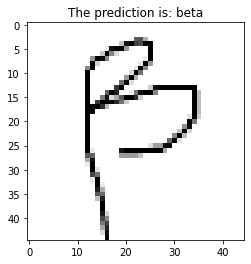

In [ ]:
# Time to work out a predictor!
# torch.save(cnn, '/content/drive/My Drive/output/model.pkl')

import matplotlib.pyplot as plt

def predict(file_name):
    file_dir = os.path.join(test_path, file_name)
    def load_picture(file_name):
        loader = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Resize((45,45)),
         torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))])
        image = Image.open(file_name).convert('L')
        image = loader(image).unsqueeze(0)
        return image.to(torch.float)
    res, _ = model(load_picture(file_dir).to(device))
    preds = torch.max(res, 1)[1]
    org_loader = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), torchvision.transforms.Resize((45,45))])
    pic_tensor = org_loader(Image.open(file_dir).convert('RGB')).squeeze().data.numpy().transpose(1,2,0)
    plt.imshow(pic_tensor)
    plt.title('The prediction is: {}'.format(idx_label(preds)))
    plt.show()


test_path = '/content/drive/My Drive/output/tests'
for pic in os.listdir(test_path):
  predict(pic)

### **Conclusion**
The experiment demonstrates the outstanding performance of Convolutional Neural Network structures in analyzing pictures and carrying out different tasks. 

The team would seek opportunities to extend the usability of the model and take on more complex tasks based on this implementation, aiming at something further and better.

For more details corresponding to the project (i.e. algorithmetic backgrounds and optimization methods), please check the final report along with the team's final submission.